### Part 1: Load Playlist Data and Build Co-occurrence Matrix

This section loads the Spotify playlist data from two JSON files and constructs a co-occurrence matrix.
Each node in the matrix represents an artist, and edges represent how often two artists appear together in playlists.
This co-occurrence matrix will be the basis for dimensionality reduction and clustering later on.


In [75]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from itertools import combinations
import numpy as np
from sklearn.preprocessing import normalize

# Need to install umap-learn package
import umap


# --- STEP 1: Load JSON and Build Co-occurrence Matrix ---

with open("data/sample_playlist_data.json", "r") as f:
    data = json.load(f)

co_occurrence = defaultdict(Counter)
uri_to_name = {}
name_artist_to_uri = {}
name_to_uris = defaultdict(set)

for playlist in data:
    for track in playlist["tracks"]:
        artist = track["artist_name"].strip()
        track_name = track["track_name"].strip()
        artist_uri = track["artist_uri"].split(":")[-1]
        uri_to_name[artist_uri] = artist
        name_artist_to_uri[(artist.lower(), track_name.lower())] = artist_uri
        name_to_uris[artist.lower()].add(artist_uri)

    artists = list({track["artist_uri"].split(":")[-1] for track in playlist["tracks"]})
    for a1, a2 in combinations(artists, 2):
        co_occurrence[a1][a2] += 1
        co_occurrence[a2][a1] += 1

# --- STEP 2: Helper to extract artist URIs ---

def get_artist_uris(song_list):
    artist_uris = []
    for song in song_list:
        artist = song["artist_name"].strip().lower()
        track = song["track_name"].strip().lower()

        if (artist, track) in name_artist_to_uri:
            artist_uris.append(name_artist_to_uri[(artist, track)])
        elif artist in name_to_uris:
            artist_uris.append(list(name_to_uris[artist])[0])

    return artist_uris

# --- STEP 3: Main Function to Build Cluster Map ---

def build_artist_cluster_map(artist_uris, co_occurrence, top_n):
    seed_artists = list(set(artist_uris))

    related_artists = set(seed_artists)
    for artist in seed_artists:
        top = co_occurrence.get(artist, {})
        most_common = sorted(top.items(), key=lambda x: -x[1])[:top_n]
        related_artists.update([a for a, _ in most_common])

    related_artists = list(related_artists)
    artist_index = {artist: i for i, artist in enumerate(related_artists)}
    M = np.zeros((len(related_artists), len(related_artists)))

    for a1 in related_artists:
        for a2, count in co_occurrence[a1].items():
            if a2 in artist_index:
                i, j = artist_index[a1], artist_index[a2]
                M[i, j] = count

    reducer = umap.UMAP(n_components=2, random_state=42)
    M_2d = reducer.fit_transform(normalize(M))

    related_uris = related_artists
    seed_uris = seed_artists

    return M_2d, related_uris, artist_index, seed_uris


### Part 2: Build Lookup Dictionary and Select Sample artists

This part defines two helper functions:
1. `build_track_id_lookup`: builds a mapping from (track_name, artist_name) → artist URI.
2. `get_artist_ids_from_list`: converts a curated list of track/artist names into corresponding artist URIs.
It uses multiple fallback strategies to ensure we find the best matching URI even if partial information is missing.

44


/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


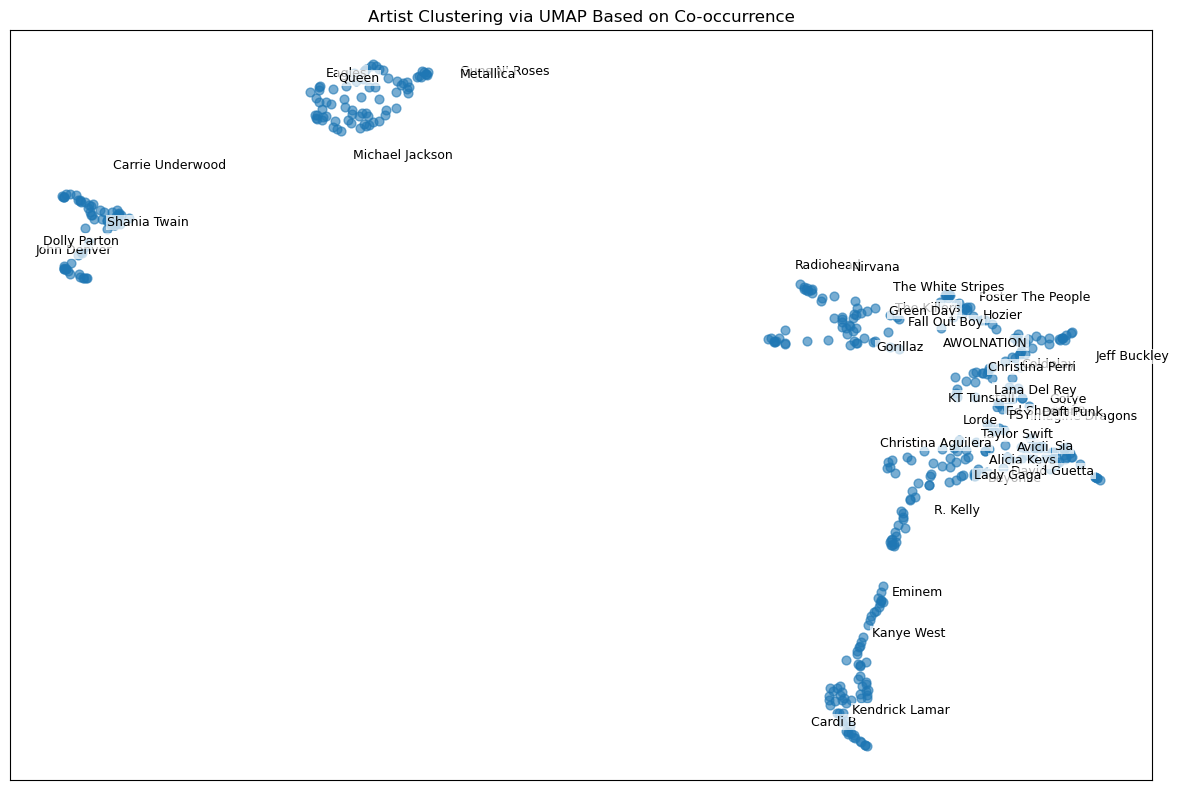

In [ ]:
# --- STEP 4: Example usage with a small sample list of popular songs during 2018 ---

sample_song_list = [
    {"track_name": "Smells Like Teen Spirit", "artist_name": "Nirvana"},            
    {"track_name": "Single Ladies", "artist_name": "Beyoncé"},                      
    {"track_name": "Lose Yourself", "artist_name": "Eminem"},                       
    {"track_name": "Hallelujah", "artist_name": "Jeff Buckley"},                    
    {"track_name": "Rolling in the Deep", "artist_name": "Adele"},                  
    {"track_name": "Take Me to Church", "artist_name": "Hozier"},                   
    {"track_name": "Bad Romance", "artist_name": "Lady Gaga"},                      
    {"track_name": "Radioactive", "artist_name": "Imagine Dragons"},                
    {"track_name": "Seven Nation Army", "artist_name": "The White Stripes"},        
    {"track_name": "Gangnam Style", "artist_name": "PSY"},                          
    {"track_name": "Old Town Road", "artist_name": "Lil Nas X"},                    
    {"track_name": "Jolene", "artist_name": "Dolly Parton"},                        
    {"track_name": "Mr. Brightside", "artist_name": "The Killers"},                 
    {"track_name": "Shake It Off", "artist_name": "Taylor Swift"},                  
    {"track_name": "Bohemian Rhapsody", "artist_name": "Queen"},                    
    {"track_name": "Titanium", "artist_name": "David Guetta"},                      
    {"track_name": "Thinking Out Loud", "artist_name": "Ed Sheeran"},               
    {"track_name": "Thriller", "artist_name": "Michael Jackson"},                  
    {"track_name": "Sail", "artist_name": "AWOLNATION"},                            
    {"track_name": "Country Roads", "artist_name": "John Denver"},                  
    {"track_name": "Chandelier", "artist_name": "Sia"},                             
    {"track_name": "Pumped Up Kicks", "artist_name": "Foster the People"},          
    {"track_name": "The Real Slim Shady", "artist_name": "Eminem"},                 
    {"track_name": "Clocks", "artist_name": "Coldplay"},                            
    {"track_name": "Bodak Yellow", "artist_name": "Cardi B"},                       
    {"track_name": "Levels", "artist_name": "Avicii"},                              
    {"track_name": "Man! I Feel Like a Woman!", "artist_name": "Shania Twain"},     
    {"track_name": "Creep", "artist_name": "Radiohead"},                            
    {"track_name": "HUMBLE.", "artist_name": "Kendrick Lamar"},                     
    {"track_name": "Royals", "artist_name": "Lorde"},                               
    {"track_name": "Boulevard of Broken Dreams", "artist_name": "Green Day"},       
    {"track_name": "A Thousand Years", "artist_name": "Christina Perri"},           
    {"track_name": "Enter Sandman", "artist_name": "Metallica"},                    
    {"track_name": "Summertime Sadness", "artist_name": "Lana Del Rey"},            
    {"track_name": "Ignition (Remix)", "artist_name": "R. Kelly"},                  
    {"track_name": "Feel Good Inc.", "artist_name": "Gorillaz"},                    
    {"track_name": "Black Horse and the Cherry Tree", "artist_name": "KT Tunstall"},
    {"track_name": "Get Lucky", "artist_name": "Daft Punk"},                        
    {"track_name": "Before He Cheats", "artist_name": "Carrie Underwood"},          
    {"track_name": "Stronger", "artist_name": "Kanye West"},                        
    {"track_name": "Somebody That I Used to Know", "artist_name": "Gotye"},         
    {"track_name": "Come As You Are", "artist_name": "Nirvana"},                   
    {"track_name": "Beautiful", "artist_name": "Christina Aguilera"},               
    {"track_name": "No One", "artist_name": "Alicia Keys"},                         
    {"track_name": "My Songs Know What You Did", "artist_name": "Fall Out Boy"},    
    {"track_name": "On Top of the World", "artist_name": "Imagine Dragons"},        
    {"track_name": "My Heart Will Go On", "artist_name": "Celine Dion"},            
    {"track_name": "Take It Easy", "artist_name": "Eagles"},                        
    {"track_name": "Sweet Child o' Mine", "artist_name": "Guns N' Roses"}, 
    {"track_name": "Billie Jean", "artist_name": "Michael Jackson"}   
]

artist_uris = get_artist_uris(sample_song_list)


# Remove duplicates while preserving order
seen = set()
unique_artist_uris = []
for uri in artist_uris:
    if uri not in seen:
        seen.add(uri)
        unique_artist_uris.append(uri)

artist_uris = unique_artist_uris

print(len(artist_uris))  #see how many were matched


M_2d, related_uris, artist_index, seed_artists = build_artist_cluster_map(
    artist_uris, co_occurrence, top_n=50
)

plt.figure(figsize=(12, 8))
plt.scatter(M_2d[:, 0], M_2d[:, 1], alpha=0.6, s=40)

for artist_uri in seed_artists:
    if artist_uri in artist_index:
        idx = artist_index[artist_uri]
        x, y = M_2d[idx, 0], M_2d[idx, 1]
        jitter_x = x + np.random.uniform(-1, 1)
        jitter_y = y + np.random.uniform(-1, 1)
        artist_name = uri_to_name.get(artist_uri, artist_uri)
        #print(artist_name)
        plt.text(
            jitter_x,
            jitter_y,
            artist_name,
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
        )

plt.title("Artist Clustering via UMAP Based on Co-occurrence")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


### Part 3: Load Genre Data from CSV and Train KNN Classifier

Here, genre information is loaded from a CSV file that contains artist URIs and their genre probabilities.
We compute the dominant genre (highest probability) for each artist, then use a K-Nearest Neighbors classifier
to predict genres for unlabeled artists in the UMAP space based on their nearest neighbors.

In [73]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Load genre probability data for tracks
# Each row is a track, and genre columns contain probabilities [0, 1]
genre_df = pd.read_csv("data/songs_with_genres_1.csv")
temp = pd.read_csv("data/songs_with_genres_2.csv")
genre_df = pd.concat([genre_df, temp])
temp = []

genre_df['artist_uri'] = genre_df['artist_uri'].astype(str).str.strip()  

# Select relevant genre columns only
genre_columns = genre_df.columns[9:15]  
print(list(genre_columns))  # Optional: print genre column names to verify


# Map each track_uri to its dominant genre (highest probability in selected columns)
artist_genre_map = {}

# Group rows by track URI (some URIs might occur multiple times in dataset)
grouped = genre_df.groupby('artist_uri')

for artist_uri, group in grouped:
    genre_means = group[genre_columns].mean()  # Average genre scores across duplicates
    top_genre = genre_means.idxmax()           # Genre with highest average probability
    artist_genre_map[artist_uri.strip()] = top_genre


def predict_genres_umap(M_2d, related_tracks, artist_genre_map, uri_to_name, k):
    X_train = []        # 2D points with known genre
    y_train = []        # Corresponding genres
    unknown_artists = [] # Tracks with no known genre

    for i, artist_uri in enumerate(related_tracks):
        artist_uri_clean = artist_uri.strip()
        if artist_uri_clean in artist_genre_map:
            X_train.append(M_2d[i])
            y_train.append(artist_genre_map[artist_uri_clean])
        else:
            unknown_artists.append((artist_uri_clean, M_2d[i]))

    
    if not X_train:
        raise ValueError("No known genres in related_artists for training.")

    # Train k-Nearest Neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict genre for each unknown track based on nearest neighbors
    predictions = {}
    for artist_uri, vec in unknown_artists:
        predictions[artist_uri] = knn.predict([vec])[0]

    return predictions  # Returns: track_uri → predicted genre 


['mood_acoustic', 'mood_sad', 'mood_party', 'mood_happy', 'mood_relaxed', 'mood_electronic']


### Part 4: Run Genre Prediction and Print Results

This final section:
1. Runs the full clustering pipeline to get 2D coordinates via UMAP.
2. Applies the trained KNN model to predict genres for artists without known labels.
3. Prints out the genre (true or predicted) for each of the seed artists that were input by the user.


In [74]:
# Run the full clustering + prediction pipeline

# This runs UMAP clustering on the selected track URIs
# Input: track_uri's from your curated track list
# Output:
#   - M_2d: 2D UMAP-reduced coordinates of tracks
#   - related_tracks: tracks included in the neighborhood expansion (including seeds)
#   - track_index: mapping from track URI → row index in M_2d
#   - seed_tracks: the input seed track IDs
M_2d, related_tracks, track_index, seed_tracks = build_artist_cluster_map(artist_uris, co_occurrence, top_n=50)

# Predict genres using KNN trained on known genre-labeled tracks
# Returns: dictionary mapping track_uri → predicted genre
predicted_genres = predict_genres_umap(M_2d, related_tracks, artist_genre_map, uri_to_name, k=5)

# Display the genre predictions for your original list of seed tracks

# For each seed track, get:
# the track's name (from the URI-to-name dictionary)
# its genre: from ground-truth genre mapping if available, otherwise from predicted KNN result
for artist_uri in seed_tracks:
    artist_name = uri_to_name.get(artist_uri, artist_uri)  # fallback to URI if name missing
    genre = artist_genre_map.get(artist_uri, predicted_genres.get(artist_uri, "Unknown"))  
    print(f"{artist_name}: {genre}") 


/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickgeis/miniconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sia: mood_relaxed
Kanye West: mood_electronic
Coldplay: mood_relaxed
Carrie Underwood: mood_happy
Imagine Dragons: mood_relaxed
Taylor Swift: mood_happy
AWOLNATION: mood_electronic
Cardi B: mood_electronic
Adele: mood_relaxed
Foster The People: mood_electronic
Alicia Keys: mood_relaxed
John Denver: mood_acoustic
Shania Twain: mood_happy
Guns N' Roses: mood_party
Radiohead: mood_relaxed
The Killers: mood_party
Nirvana: mood_party
Green Day: mood_party
The White Stripes: mood_party
KT Tunstall: mood_relaxed
Metallica: mood_party
Hozier: mood_relaxed
Eagles: mood_relaxed
Ed Sheeran: mood_relaxed
Gotye: mood_relaxed
Daft Punk: mood_electronic
Eminem: mood_electronic
Lorde: mood_relaxed
Dolly Parton: mood_acoustic
Fall Out Boy: mood_party
Michael Jackson: mood_electronic
Kendrick Lamar: mood_electronic
Christina Perri: mood_relaxed
Beyoncé: mood_electronic
Gorillaz: mood_electronic
R. Kelly: mood_relaxed
Jeff Buckley: mood_relaxed
PSY: mood_electronic
Lana Del Rey: mood_relaxed
Avicii: mood